## Finding an estimate for tracer concentration on the downstream side of the canyon

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import scipy.stats 
import seaborn as sns
import xarray as xr

In [2]:
# Set appearance options seaborn

sns.set_style('white')
sns.set_context('talk')

# Set necessary grid variables and grid file
grid = xr.open_dataset('/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc')
rc = grid.RC


In [3]:
# Create an empty class to save information of every run

class run:
    pass

In [4]:
def linear_regression(x, y, prob):
    """
    Return the linear regression parameters and their <prob> confidence intervals.
    ex:
    >>> linear_regression([.1,.2,.3],[10,11,11.5],0.95)
    """
    x = np.array(x)
    y = np.array(y)
    n = len(x)
    xy = x * y
    xx = x * x

    # estimates

    b1 = (xy.mean() - x.mean() * y.mean()) / (xx.mean() - x.mean()**2)
    b0 = y.mean() - b1 * x.mean()
    s2 = 1./n * sum([(y[i] - b0 - b1 * x[i])**2 for i in range(n)])
    print ('b0 = ',b0)
    print ('b1 = ',b1)
    print ('s2 = ',s2)
    
    #confidence intervals
    
    alpha = 1 - prob
    c1 = scipy.stats.chi2.ppf(alpha/2.,n-2)
    c2 = scipy.stats.chi2.ppf(1-alpha/2.,n-2)
    print ('the confidence interval of s2 is: ',[n*s2/c2,n*s2/c1])
    
    c = -1 * scipy.stats.t.ppf(alpha/2.,n-2)
    bb1 = c * (s2 / ((n-2) * (xx.mean() - (x.mean())**2)))**.5
    print ('the confidence interval of b1 is: ',[b1-bb1,b1+bb1])
    
    bb0 = c * ((s2 / (n-2)) * (1 + (x.mean())**2 / (xx.mean() - (x.mean())**2)))**.5
    print ('the confidence interval of b0 is: ',[b0-bb0,b0+bb0])
    return ([n*s2/c2,n*s2/c1],[b1-bb1,b1+bb1],[b0-bb0,b0+bb0])

In [5]:
import os
import sys
lib_path = os.path.abspath('../PythonScripts/Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records 
import nocanyon_records

In [6]:
records = canyon_records.main()
recordsNoC = nocanyon_records.main()

# records2 has all the runs without the ones where K_bg changes. I don't want to use this ones for fitting the data
ind = [0,3,4,5,10,11,12,13,14,15,16,17,18,19,20,21]

records2 = []
recordsNoC2 = []
for ii in ind:
    records2.append(records[ii])
    recordsNoC2.append(recordsNoC[ii])
ii=0
for rec in records2:
    print(ii,rec.name)
    ii=ii+1



0 CNTDIFF_run38
1 CNTDIFF_run45
2 CNTDIFF_run73
3 CNTDIFF_run75
4 3DVISC_run01
5 3DVISC_run02
6 3DVISC_run04
7 3DVISC_run03
8 3DVISC_run05
9 3DVISC_run06
10 LOWER_BF_run01
11 LOW_BF_run01
12 LOWEST_BF_run01
13 LOWEST_BF_run03
14 LOWEST_BF_run05
15 LOWEST_BF_run07


In [7]:
# Constants and scales

L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Wsb = 13000 # Width at shelf break
Hs = 147.5 # Shelf break depth
Hh = 97.5 # 
Hr = 132.0 # rim depth at dn station
# NOTE: The default values of all functions correspond to the base case

def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    retun(f*L/(N))
    
def Z(U=0.36,L=6400.0,N=5.5E-3,R=5000.0):
    '''Depth of upwelling as scaled in Allen and Hickey 2010'''
    return((1.4*U*(L**(1/2)))/(Nos*(R**(1/2))))

def Ro(U=0.36,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the hability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Rw(U=0.36,f=9.66E-5,Wsb=13000.0): 
    '''Rossby number using width at shelf break as length scale'''
    return(U/(f*Wsb))

def Bu(N=5.5E-3,f=9.66E-5,L=6400.0,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*L))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)


In [8]:
# Save mean maximum N of days 3-6 and std for each run.

keys = ['dTrdz_tt08','dTrdz_tt10','dTrdz_tt12','dTrdz_tt14','dTrdz_tt16']
key0 = 'dTrdz_tt00'
stname = 'DnC' # Station at downstream side of canyon

for record in records:
    
    filename1 = ('../results/metricsDataFrames/dTr1dz_%s_%s.csv' % (record.name,stname))
    df = pd.read_csv(filename1)
    
    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])
        
    maxd3 = min(df_anom[keys[0]][22:26])   
    maxd4 = min(df_anom[keys[1]][22:26])   
    maxd5 = min(df_anom[keys[2]][22:26])   
    maxd6 = min(df_anom[keys[3]][22:26])   
    maxd7 = min(df_anom[keys[4]][22:26])   
    
    
    record.maxdTrdz = np.mean(np.array([maxd3,maxd4,maxd5,maxd6]))
    record.stddTrdz = np.std(np.array([maxd3,maxd4,maxd5,maxd6]))
    record.inidTrdz = df[key0][26]
 
    maxd3 = min(df_anom[keys[0]][26:31])   
    maxd4 = min(df_anom[keys[1]][26:31])   
    maxd5 = min(df_anom[keys[2]][26:31])   
    maxd6 = min(df_anom[keys[3]][26:31])   
    maxd7 = min(df_anom[keys[4]][26:31])   
    
    
    record.maxdTrdz2 = np.mean(np.array([maxd3,maxd4,maxd5,maxd6]))
    record.stddTrdz2 = np.std(np.array([maxd3,maxd4,maxd5,maxd6]))
    record.inidTrdz2 = df[key0][30]




### Tr vertical gradient proportional to isopycnal tilting

Similarly to what we did for N, 
N/No represents the relative increase of stratification from the initial value after the upwelling adjustment has occured. It makes sense to think that this relation is proportional to the tilting of isopycnals within the canyon, given by $Z$, where $Z$ is the depth of upwelling, non-dimentionalized by Hs, the depth of the shelf break. This ight not be the right scale for this but for now and since I am not changing the canyon, I will keep this.

$$\frac{\nabla_zC}{\nabla_zCo}=\beta \frac{Z}{H_s}$$

where $Z = \frac{{fu\mathcal{F}L}^{1/2}}{N_0}$, $\mathcal{F}$ is $Ro/(1+Ro/0.9)$, $Ro$ is a Rossy number with $\mathcal{R}$ as a length scale (Howatt and Allen (2013) say it should be $Wsb$). This leaves



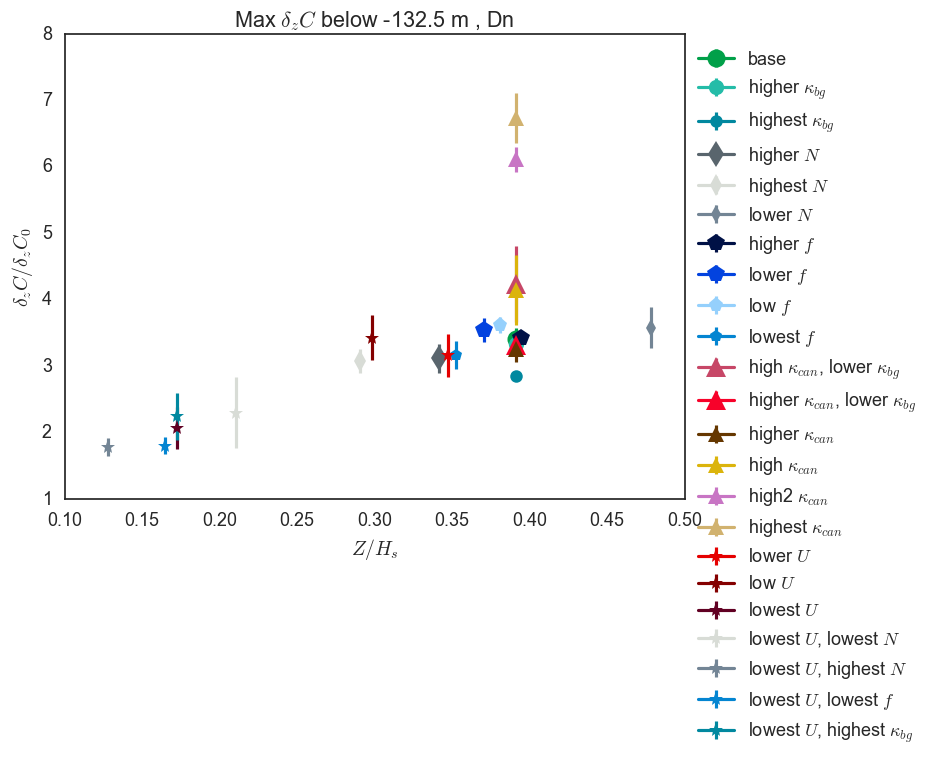

In [9]:

stname = 'DnC' # Station at downstream side of canyon

fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]

for rec in records:
    
    plt1 = ax.errorbar(((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/(Hs*rec.N),rec.maxdTrdz/rec.inidTrdz,
                       yerr = rec.stddTrdz/rec.inidTrdz, # since rec.N is a constant
                       marker = rec.mstyle,
                       markersize = rec.msize,
                       color = sns.xkcd_rgb[rec.color],
                       label=rec.label)
   
    ax.set_title('Max $\delta_zC$ below %1.1f m , Dn' %rc[26])
    ax.set_ylabel('$\delta_zC/\delta_zC_0$')
    ax.set_xlabel('$Z/H_s$')

    ax.legend(bbox_to_anchor=(1.4,1))
#ax.set_xscale('log')    

plt.show()


## Let's add $\kappa_v$

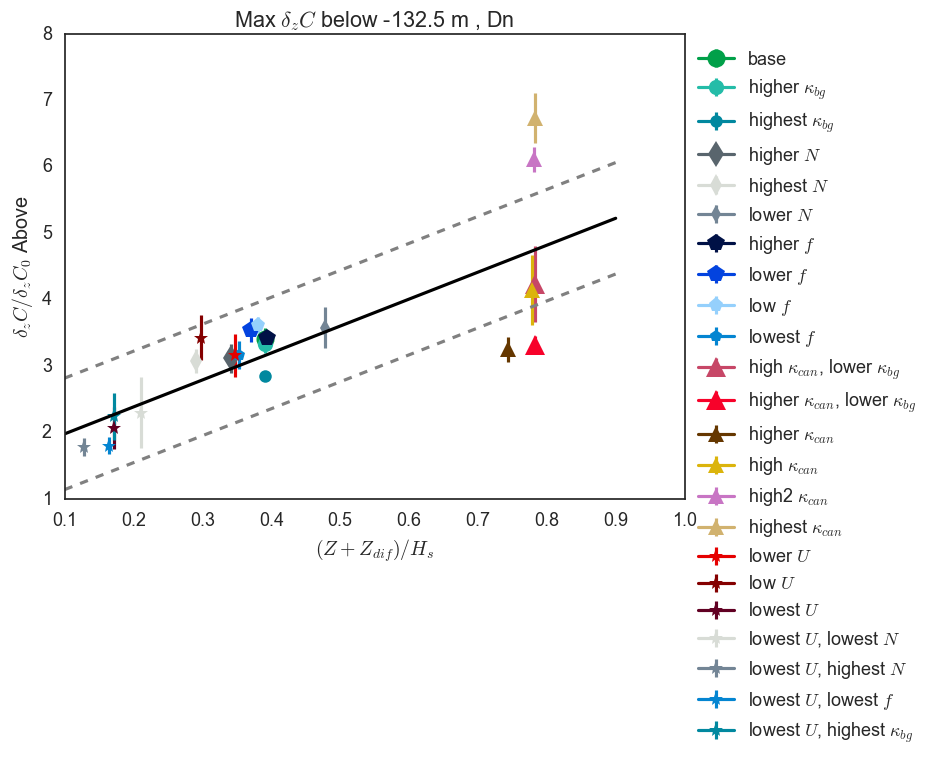

In [17]:
stname = 'DnC' # Station at downstream side of canyon

fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]
t=6 # days


for rec in records:
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    sq = ((rec.kbg-rec.kv)/(-rec.kv))*(Z/Hs)
    
    Zdif = np.sqrt(t*3600*24*(rec.kv-rec.kbg))
    plt1 = ax.errorbar(((Z/Hs)+sq),(rec.maxdTrdz/rec.inidTrdz),
                       yerr = rec.stddTrdz/rec.inidTrdz, # since rec.N is a constant
                       marker = rec.mstyle,
                       markersize = rec.msize,
                       color = sns.xkcd_rgb[rec.color],
                       label=rec.label)
   
    ax.set_title('Max $\delta_zC$ below %1.1f m , Dn' %rc[26])
    ax.set_ylabel('$\delta_zC/\delta_zC_0$ Above')
    ax.set_xlabel(r'$(Z+Z_{dif})/H_s$')

    ax.legend(bbox_to_anchor=(1.4,1))
    rec.Zdif = Zdif 
    rec.Z = Z
    rec.sq = sq
#ax.set_xscale('log')    

# Linear fit

maxN_array_Kv = np.array([rec.maxdTrdz/rec.inidTrdz for rec in records2])
#tilt_array_Kv = np.array([((rec.Z+rec.Zdif)/Hs) for rec in records2]) 
tilt_array_Kv = np.array([(rec.Z/Hs)+(rec.sq) for rec in records2]) 
                          

x_fit = np.linspace(0.1, 0.9, 50)

slope_Kv, intercept_Kv, r_value_Kv, p_value_Kv, std_err_Kv = scipy.stats.linregress(tilt_array_Kv,maxN_array_Kv)

plt3 = ax.plot(x_fit,slope_Kv*x_fit+intercept_Kv,'-k',label='linear fit')

mean_sq_err_Kv = np.mean((maxN_array_Kv-(slope_Kv*tilt_array_Kv+intercept_Kv))**2)

upper_bound = ax.plot(x_fit,slope_Kv*x_fit+intercept_Kv+(mean_sq_err_Kv)**(0.5),linestyle = '--',color='0.5', label = 'fit$\pm\sqrt{mean\,sq\,error}$')
lower_bound = ax.plot(x_fit,slope_Kv*x_fit+intercept_Kv-(mean_sq_err_Kv)**(0.5),linestyle = '--',color='0.5')

plt.show()


In [1]:
# Let's see it if works


stname = 'DnC' # Station at downstream side of canyon

fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]
t=6 # days
ax.plot(np.linspace(1,7.0,50),np.linspace(1,7,50),'k-')

for rec in records:
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    
    Zdif = np.sqrt(t*3600*24*(rec.kv-rec.kbg))
    
    plt1 = ax.errorbar((slope_Kv*((Z+Zdif)/Hs))+intercept_Kv,rec.maxdTrdz/rec.inidTrdz,
                       yerr = rec.stddTrdz/rec.inidTrdz, # since rec.N is a constant
                       marker = rec.mstyle,
                       markersize = rec.msize,
                       color = sns.xkcd_rgb[rec.color],
                       label=rec.label)
    
    ax.set_title('Max $\delta_zC$ below %1.1f m , Dn' %rc[26])
    ax.set_ylabel('$\delta_zC/\delta_zC_0$ Above' )
    ax.set_xlabel(r'$%1.2f((Z+Z_{dif})/H_s))+%1.2f$' %(slope_Kv,intercept_Kv))
   
    ax.legend(bbox_to_anchor=(1.4,1))

    
    
plt.show()


NameError: name 'plt' is not defined

### Can I get an average tracer concentration from this approximation?

If I approximate the tracer concentration profile as being linear around a small depth between canyon head and shelf break depth:

$$C \approx \delta_zC z + b$$

Then I can calculate the average concentration $\bar{C}$ as :

$$\bar{C}=\frac{1}{H_{sb}-H_{h}}\int_{H_{sh}}^{H_h}(\delta_zC z + b) dz$$

$$\bar{C}=\frac{\delta_zC}{2}(H_{sb}+H_h)+b$$

In [ ]:
keys = ['Tr_profile_tt08','Tr_profile_tt10','Tr_profile_tt12','Tr_profile_tt14','Tr_profile_tt16']
key0 = 'Tr_profile_tt00'
stname = 'DnC' # Station at downstream side of canyon

for record in records:
    
    filename1 = ('../results/metricsDataFrames/Tr1_profile_%s_%s.csv' % (record.name,stname))
    df = pd.read_csv(filename1)
    df_anom=(df.sub(df[key0].squeeze(),axis=0))
    maxd4 = np.mean(df[keys[0]][25:32])   
    maxd5 = np.mean(df[keys[1]][25:32])   
    maxd6 = np.mean(df[keys[2]][25:32]) 
    maxd7 = np.mean(df[keys[3]][25:32])  
    maxd8 = np.mean(df[keys[4]][25:32])  
    
     
    maxd0 = df[key0][29]
    
    
    record.maxTr = np.mean(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    record.stdTr = np.std(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    
    
    record.maxTr0 = maxd0
Ctop = df[key0][0]

In [ ]:
# Let's see it if works

# Choose only the runs that satisfy all restrictions in Allen and Hickey (2010)

stname = 'DnC' # Station at downstream side of canyon

fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]
t=6 # days
for rec in records: 
    
    plt1 = ax.errorbar((-rec.maxdTrdz*(Hh+Hr))/2.0,rec.maxTr,
                   yerr = rec.stdTr,
                    marker = rec.mstyle,
                    markersize = rec.msize,
                    color = sns.xkcd_rgb[rec.color],
                    label=rec.label)
   
    ax.set_title('Max tracer concentration between %1.1f m and %1.1f m, Dn' %(rc[26],rc[31]))
    ax.set_ylabel('$max(C)$ ')
    ax.set_xlabel('$(\delta_zC/2)(H_{r}+H_h)$')

    ax.legend(bbox_to_anchor=(1.6,1))
#ax.set_xscale('log')    

plt.show()


In [ ]:
# Let's see it if works

stname = 'DnC' # Station at downstream side of canyon

fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]
t=6 # days
for rec in records:
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    Zdif = np.sqrt(t*3600*24*(rec.kv-rec.kbg))
    
    dTrdz = -rec.inidTrdz*(6.27*(((Z+Zdif)/Hs))+0.98)
  
    plt1 = ax.errorbar(dTrdz*(Hh+Hr)/2.0,rec.maxTr,
                        yerr = rec.stdTr,
                        marker = rec.mstyle,
                        markersize = rec.msize,
                        color = sns.xkcd_rgb[rec.color],
                        label=rec.label)
    rec.dTrdz = dTrdz
    ax.set_title('Max tracer concetration between %1.1f m and %1.1f m, Dn' %(rc[26],rc[30]))
    ax.set_ylabel('Max Conc between head and shelf break depth')
    ax.set_xlabel(r'$\delta_zC_0((Z+Z_{dif})/H_s)(H_{rim}+H_h)/2$')

    ax.legend(bbox_to_anchor=(1.4,1))
#ax.set_xscale('log')    
#ax.plot(np.linspace())
# Linear fit

maxN_array_Kv = np.array([rec.maxTr for rec in records2])
tilt_array_Kv = np.array([rec.dTrdz*(Hh+Hr)/2.0 for rec in records2])

x_fit = np.linspace(5,26, 50)

slope_Kv, intercept_Kv, r_value_Kv, p_value_Kv, std_err_Kv = scipy.stats.linregress(tilt_array_Kv,maxN_array_Kv)

plt3 = ax.plot(x_fit,slope_Kv*x_fit+intercept_Kv,'-k',label='linear fit')

mean_sq_err_Kv = np.mean((maxN_array_Kv-(slope_Kv*tilt_array_Kv+intercept_Kv))**2)

upper_bound = ax.plot(x_fit,slope_Kv*x_fit+intercept_Kv+(mean_sq_err_Kv)**(0.5),linestyle = '--',color='0.5', label = 'fit$\pm\sqrt{mean\,sq\,error}$')
lower_bound = ax.plot(x_fit,slope_Kv*x_fit+intercept_Kv-(mean_sq_err_Kv)**(0.5),linestyle = '--',color='0.5')

plt.show()


In [ ]:
# Let's see it if works

stname = 'DnC' # Station at downstream side of canyon

fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]
t=6 # days

for rec in records:
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    Zdif = np.sqrt(t*3600*24*(rec.kv-rec.kbg))
    dTrdz = -rec.inidTrdz*(6.27*(((Z+Zdif)/Hs))+0.98)
  
    plt1 = ax.errorbar(-rec.inidTrdz*(Z+Zdif) - rec.inidTrdz + Ctop,rec.maxTr,
                        yerr = rec.stdTr,
                        marker = rec.mstyle,
                        markersize = rec.msize,
                        color = sns.xkcd_rgb[rec.color],
                        label=rec.label)
    rec.dTrdz = dTrdz
    ax.set_title('Max tracer concetration between %1.1f m and %1.1f m, Dn' %(rc[26],rc[30]))
    ax.set_ylabel('Max Conc between head and shelf break depth')
    ax.set_xlabel(r'$\delta_zC_0((Z+Z_{dif})/H_s)(H_{rim}+H_h)/2$')

    ax.legend(bbox_to_anchor=(1.4,1))

plt.show()


In [ ]:

# Let's see it if works

stname = 'DnC' # Station at downstream side of canyon

fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]
t=6 # days
ax.plot(np.linspace(1,1.3,50),np.linspace(1,1.3,50),'k-')
    
for rec in records:
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    Zdif = np.sqrt(t*3600*24*(rec.kv-rec.kbg))
    
    dTrdz = -rec.inidTrdz*(6.27*(((Z+Zdif)/Hs))+0.98)
  
    plt1 = ax.errorbar((slope_Kv*(dTrdz*(Hh+Hr)/2.0)+intercept_Kv)/record.maxTr0,rec.maxTr/rec.maxTr0,
                        yerr = rec.stdTr/rec.maxTr0,
                        marker = rec.mstyle,
                        markersize = rec.msize,
                        color = sns.xkcd_rgb[rec.color],
                        label=rec.label)
    
    ax.set_title('Mean tracer concetration between %1.1f m and %1.1f m, Dn' %(rc[22],rc[32]))
    ax.set_ylabel('Mean Conc between head and shelf break depth (non dim) ')
    ax.set_xlabel(r'%1.2f$(\delta_zC_0((Z+Z_{dif})/H_s)(H_{rim}+H_h)/2)+$%1.2f' %(slope_Kv/record.maxTr0,intercept_Kv/record.maxTr0))

    ax.legend(bbox_to_anchor=(1.4,1))

plt.show()


In [ ]:
print(slope_Kv,intercept_Kv)

In [12]:
(1E-5-1E-3)/(1E-5+1E-3)

-0.9801980198019802

In [13]:
(1E-5-1E-2)/(1E-5+1E-2)

-0.9980019980019981

In [14]:
(1E-5-5E-3)/(1E-5+5E-3)

-0.9960079840319362